# Demo - The Role of Eccentricity
This demo uses ``LEGWORK`` to illustrate the role of eccentricity in the detectability of a gravitational wave source in LISA.

In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("../../")

import legwork
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

In [184]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

## Sensitivity curve

In [232]:
# set eccentricities
ecc = np.array([1e-6, 0.6, 0.9])
n_binaries = len(ecc)

# use constant values for mass, f_orb and distance
m_1 = np.repeat(0.6, n_binaries) * u.Msun
m_2 = np.repeat(0.6, n_binaries) * u.Msun
f_orb = np.repeat(1.5e-3, n_binaries) * u.Hz
dist = np.repeat(15, n_binaries) * u.kpc

# m_c = legwork.utils.chirp_mass(m_1, m_2)

snr2_n = legwork.snr.snr_ecc_evolving(m_1=m_1, m_2=m_2, f_orb_i=f_orb, ecc=ecc, dist=dist,
                                      harmonics_required=100, t_obs=4 * u.yr, n_step=1000,
                                      ret_snr2_by_harmonic=True)

sources = legwork.source.Source(m_1=m_1, m_2=m_2, f_orb=f_orb, dist=dist, ecc=ecc, interpolate_g=False)
sources.get_snr()

array([31.73909117, 50.18717598, 38.76225257])

In [236]:
np.array([31.73909117, 50.18717598, 38.76225257]).round(1)

array([31.7, 50.2, 38.8])

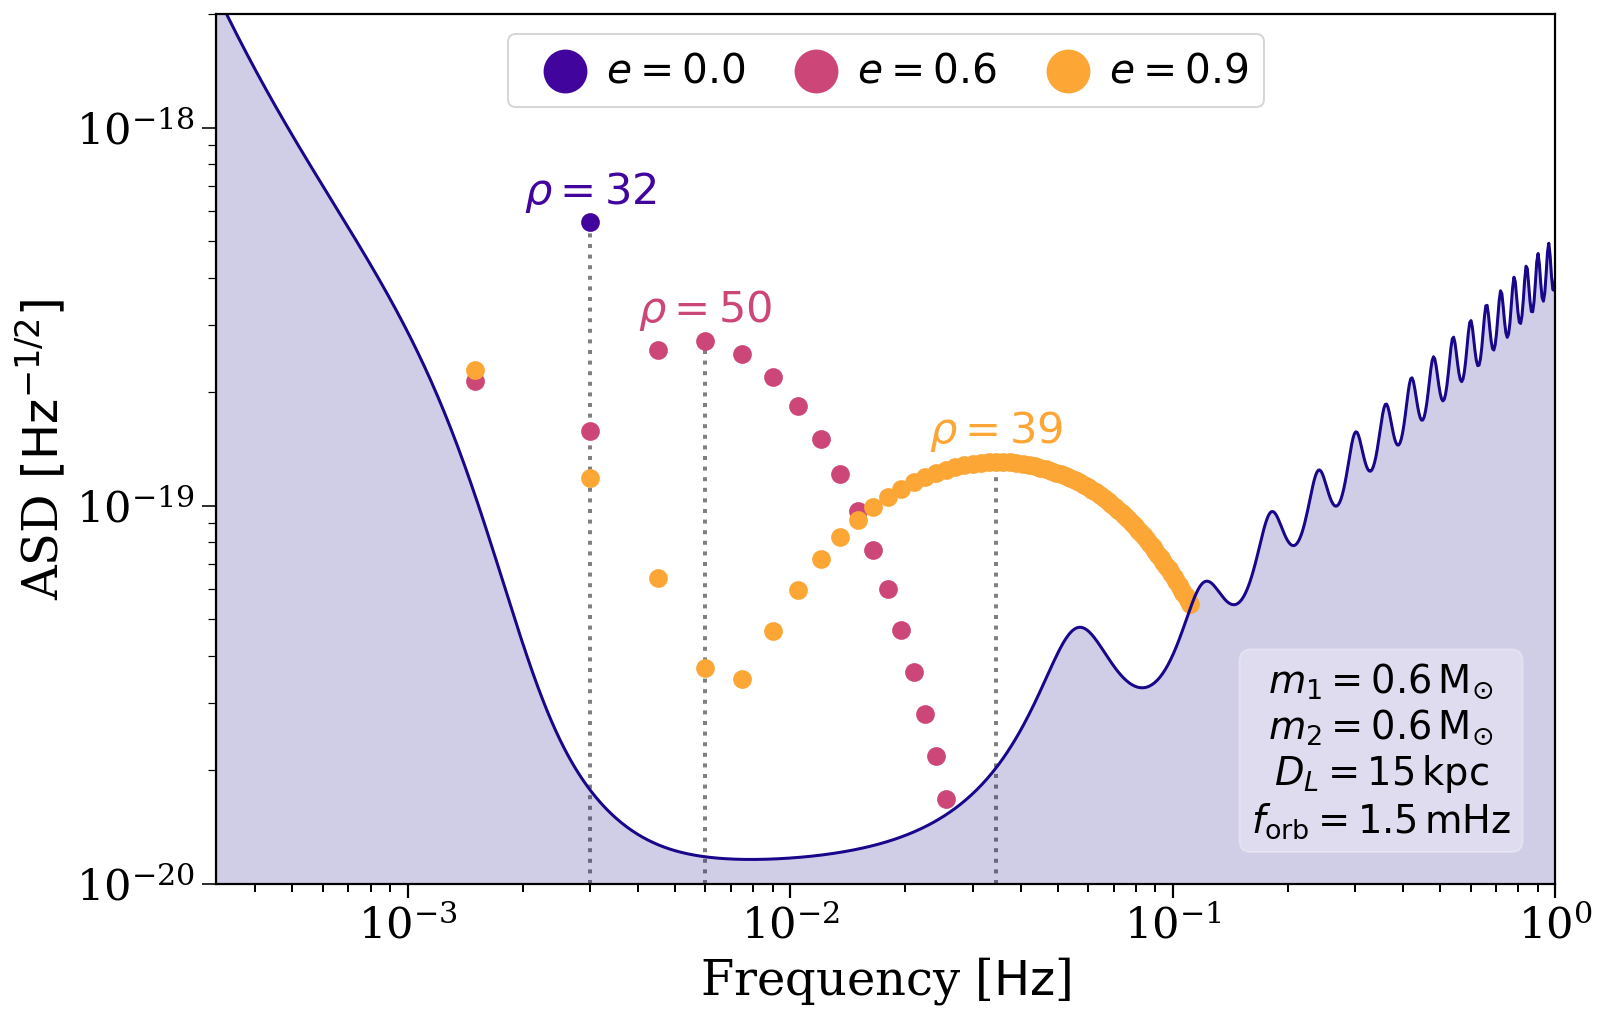

In [239]:
fig, ax = legwork.visualisation.plot_sensitivity_curve(frequency_range=np.logspace(-3.5, 0, 1000) * u.Hz,
                                                       show=False)

colours = [plt.get_cmap("plasma")(i) for i in [0.1, 0.5, 0.8]]

for i in range(len(snr2_n)):
    f_harm = f_orb[i] * range(1, len(snr2_n[0]) + 1)
    y_vals = legwork.psd.lisa_psd(f_harm)**(0.5) * np.sqrt(snr2_n)[i]
    mask = np.sqrt(snr2_n)[i] > 1.0
    max_index = np.argmax(y_vals[1:]) + 1
    ax.scatter(f_harm[mask], y_vals[mask],
               s=70, color=colours[i],
               label=r"$e={{{:1.1f}}}$".format(ecc[i]))
    
    ax.annotate(r"$\rho={{{:1.0f}}}$".format(snr2_n[i].sum()**(0.5)),
                xy=(f_harm[max_index].value, y_vals[max_index].value * 1.05),
                ha="center", va="bottom", fontsize=0.9*fs, color=colours[i])
    
    ax.plot([f_harm[max_index].value] * 2, [1e-20, y_vals[max_index].value],
               color="grey", linestyle="dotted", lw=2, zorder=0)

ax.legend(markerscale=2.5, handletextpad=0.0, ncol=3, loc="upper center", columnspacing=0.75, fontsize=0.85 * fs)

annotation_string = r"$m_1 = 0.6 \, {\rm M_{\odot}}$"
annotation_string += "\n"
annotation_string += r"$m_2 = 0.6 \, {\rm M_{\odot}}$"
annotation_string += "\n"
annotation_string += r"$D_L = 15 \, {\rm kpc}$"
annotation_string += "\n"
annotation_string += r"$f_{\rm orb} = 1.5 \, {\rm mHz}$"

ax.annotate(annotation_string, xy=(3.5e-1, 1.3e-20), ha="center", va="bottom", fontsize=0.8 * fs,
            bbox=dict(boxstyle="round", fc="white", ec="white", alpha=0.3))
    
ax.set_ylim(1e-20, 2e-18)

plt.savefig("/Users/tomwagg/Documents/LW_paper/role_eccentricity.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [205]:
f_orb_s = np.logspace(-4, -1, 250) * u.Hz
ecc_s = np.linspace(0, 0.9, 100)
F, E = np.meshgrid(f_orb_s, ecc_s)

F_flat, E_flat = F.flatten(), E.flatten()

m_1 = np.repeat(10, len(F_flat)) * u.Msun
m_2 = np.repeat(10, len(F_flat)) * u.Msun
dist = np.repeat(8, len(F_flat)) * u.kpc

sources = lw.source.Source(m_1=m_1, m_2=m_2, f_orb=F_flat, ecc=E_flat, dist=dist, interpolate_sc=False)

## Merger time

In [125]:
f_range = np.logspace(-5, -1, 100) * u.Hz
e_range = np.linspace(0, 0.995, 500)

m_1 = np.repeat(10, len(f_range) * len(e_range)) * u.Msun
m_2 = np.repeat(10, len(f_range) * len(e_range)) * u.Msun

F, E = np.meshgrid(f_range, e_range)

t_merge = evol.get_t_merge_ecc(ecc_i=E.flatten(), f_orb_i=F.flatten(), m_1=m_1, m_2=m_2).reshape(F.shape)

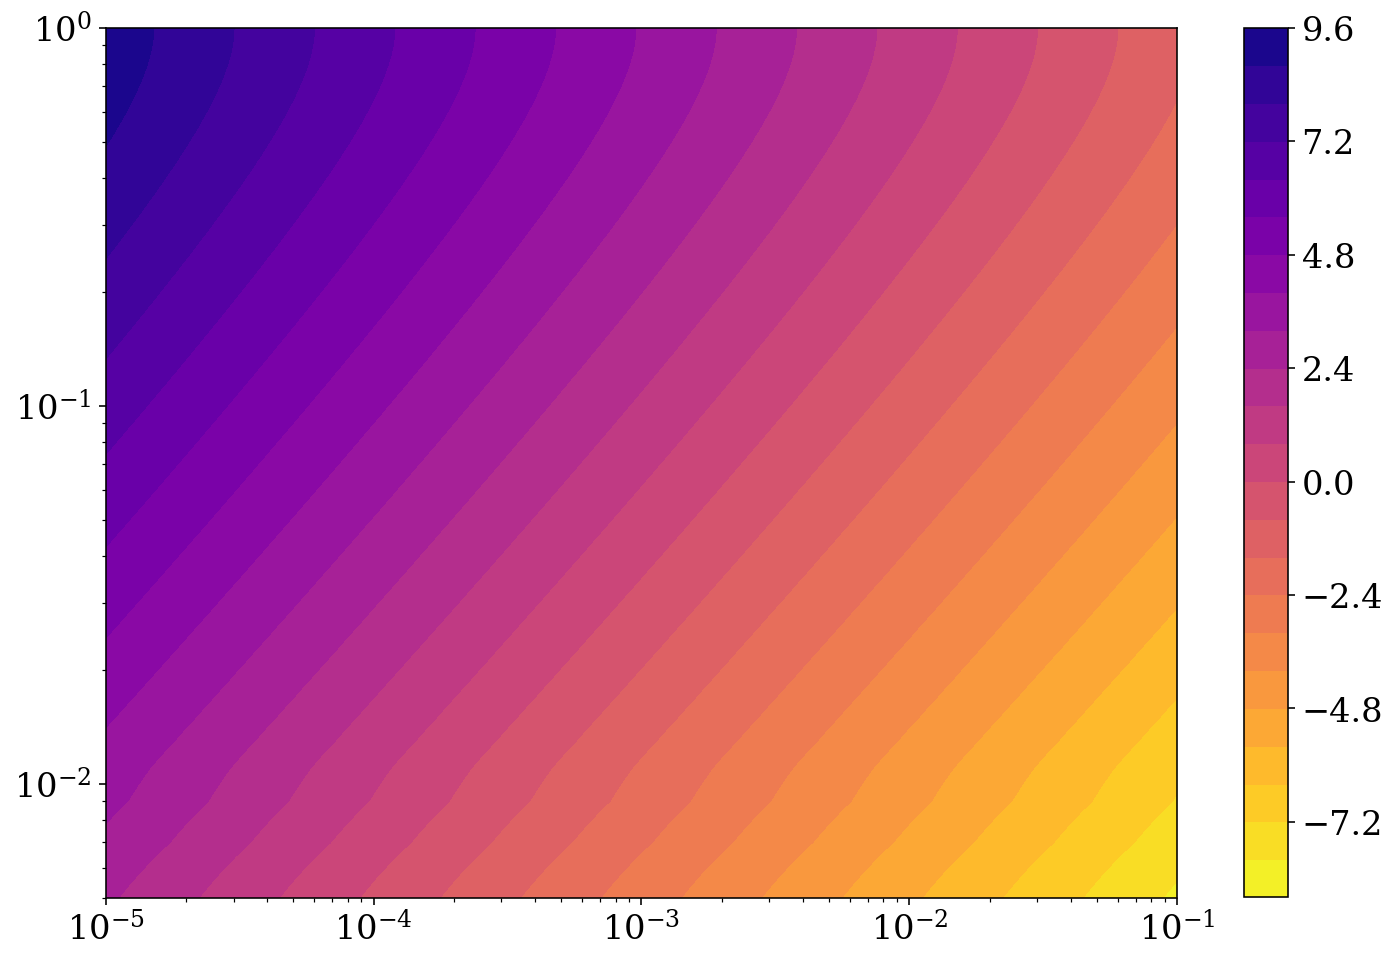

In [127]:
cont = plt.contourf(F, 1 - E, np.log10(t_merge.to(u.yr).value), cmap="plasma_r", levels=25)
plt.colorbar(cont)
plt.xscale("log")
plt.yscale("log")